In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.interpolate import interp1d, splrep, splev
import pandas as pd
from scipy import interpolate

%load_ext autoreload
%autoreload 2
from utils import *

In [2]:
def fill_nan(A):
    inds = np.arange(A.shape[0]) 
    good = np.where(np.isfinite(A))
    if(len(good[0]) <= 1):
        return A
   
    # linearly interpolate and then fill the extremes with the mean (relatively similar to)
    # what kalman does 
    f = interpolate.interp1d(inds[good], A[good],kind="linear",bounds_error=False,fill_value="extrapolate")
    B = np.where(np.isfinite(A),A,f(inds))
    B = np.where(np.isfinite(B),B,np.nanmean(B))
    return B

def mean_perc(ts):
    ts = ts[ts > np.percentile(ts,5)]
    ts = ts[ts < np.percentile(ts,95)]
    return np.mean(ts)

def center_ts(res):
    res.shape

    scale = (res[:,(NECK*3):(NECK*3+3)] - res[:,(MHIP*3):(MHIP*3+3)])[:,:2]
    scale = np.sqrt(np.sum(scale**2,axis=1))
    scale = mean_perc(scale)
    
    X = mean_perc(res[:,RANK])
    Y = mean_perc(res[:,RANK])
    
    for i in range(25):
        res[:,(i*3):(i*3+3)] = res[:,(i*3):(i*3+3)] - np.hstack([X,Y,0])[None,:]
    return res /scale #[:,None]

def plot_ts(res):
    # Features to plot for diagnostics
    PLOT_COLS = {
        "Left knee": LKNE,
        "Right knee": RKNE,
        "Left hip": LHIP,
        "Right hip": RHIP,
        "Nose": NOSE,
    }

    for name, col in PLOT_COLS.items():
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.title(name,fontsize=24)
        plt.xlabel("frame",fontsize=17)
        plt.ylabel("position",fontsize=17)
        plt.plot(res[:,[col*3,]], linestyle="-", linewidth=2.5)
        plt.plot(res[:,[col*3+1,]], linestyle="-", linewidth=2.5)
        plt.legend(['x', 'y'],loc=1)

def get_segments(res):
    nose_y = res[:,[NECK*3+1,]]
    x=range(len(nose_y))
    f = splrep(x, nose_y, s=1)
    nose_y_smooth = splev(x, f)
    peaks,_ = peakdet(nose_y_smooth, (nose_y.max() - nose_y.min())/3  )

    plt.title("Peaks of the nose",fontsize=24)
    plt.xlabel("frame",fontsize=17)
    plt.ylabel("position",fontsize=17)
    plt.plot(nose_y, linestyle="-", linewidth=2.5)
    plt.plot(nose_y_smooth, linestyle="-", linewidth=2.5)
    for i in range(peaks.shape[0]):
        plt.axvline(x=peaks[i,0],linewidth=2, color='g', linestyle="--")
    plt.show()

    n = peaks.shape[0]

    # TODO we can get a better estimate of breaks from multiple signals at once
    breaks = peaks[:,0].astype(np.uint16)
    breaks.sort()

    return breaks

def get_angle_stats(A, B, C, res, breaks, name = None):
    langle = get_angle(A, B, C, res)
    minv = []
    maxv = []
    for i in range(len(breaks)-1):
        y = (langle[breaks[i]:breaks[i+1]])*180/np.pi
        minv.append(y.min())
        maxv.append(y.max())
    return {
        "{}_max".format(name): max(maxv),
        "{}_min".format(name): max(minv),
        "{}_max_sd".format(name): np.array(maxv).std(),
        "{}_min_sd".format(name): np.array(minv).std(),
    }
    
def get_angles_results(res, breaks):
    results = {}
    results.update(get_angle_stats(LANK, LKNE, LHIP, res, breaks, name="left_knee"))
    results.update(get_angle_stats(RANK, RKNE, RHIP, res, breaks, name="right_knee"))
    results.update(get_angle_stats(LKNE, LHIP, NECK, res, breaks, name="left_hip"))
    results.update(get_angle_stats(RKNE, RHIP, NECK, res, breaks, name="right_hip"))
    res_tmp = res.copy()
    ground = np.zeros([res_tmp.shape[0],3])
    ground[:,1] = ground[:,1] - 1
    res_tmp = np.hstack([res_tmp, ground])
    results.update(get_angle_stats(NECK, MHIP, 25, res_tmp, breaks, name="trunk"))
    return results

def get_time_results(res, breaks):
    times = []
    speeds = []

    for i in range(len(breaks)-1):
        time = (breaks[i+1] - breaks[i])/FPS
        speed = 1/time

        times.append(time)
        speeds.append(speed)

    first = breaks[0]
    last = breaks[-1]
    n = len(breaks)
    total_time = n*(last-first)/((n-1)*FPS)

    return {
        "n": len(breaks),
        "time": total_time,
        "speed": round(5/total_time,2),
        "time_sd": np.array(times).std(),
        "speed_sd": np.array(speeds).std(),
    }

def get_acceleration(joint, res):
    n = res.shape[0]
    return res[1:n,(joint*3):(joint*3+3)] - res[0:(n-1),(joint*3):(joint*3+3)]

def get_avg_acceleration(joint, res, breaks):
    trunk_acc = get_acceleration(joint, res)[:,0:2]
    trunk_acc_mag = np.sum(trunk_acc**2, axis=1)
    first = breaks[0]
    last = breaks[-1]
    trunk_acc_mag = trunk_acc_mag[first:last]
    return trunk_acc_mag[trunk_acc_mag < np.percentile(trunk_acc_mag, 95)].mean()

def get_acceleration_results(res, breaks):
    return {
        "avg_pelvis_acc": get_avg_acceleration(MHIP, res, breaks),
        "avg_neck_acc": get_avg_acceleration(MHIP, res, breaks),
    }

9QrMwwEK


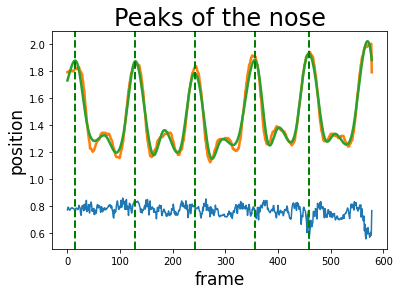

hozGKSGr


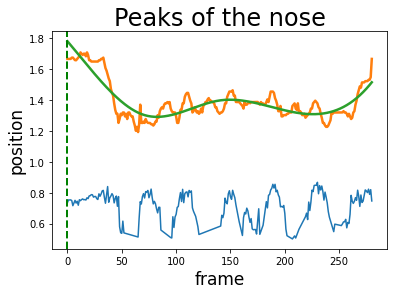

0eHy4fTr


/home/kidzik/miniconda3/envs/motionlab-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in true_divide
/home/kidzik/miniconda3/envs/motionlab-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/kidzik/miniconda3/envs/motionlab-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/kidzik/miniconda3/envs/motionlab-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


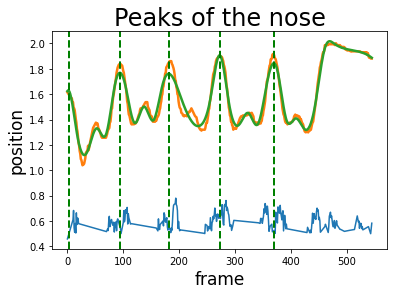

BgJDWIJz


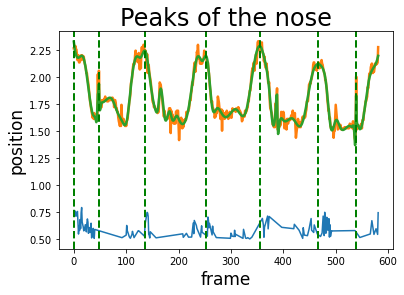

bzh3pQlt


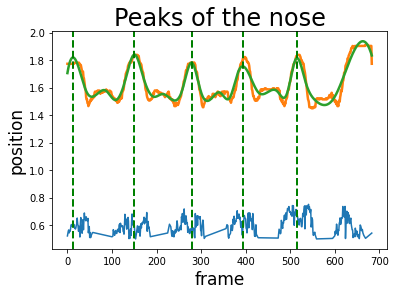

OJk9GuJF


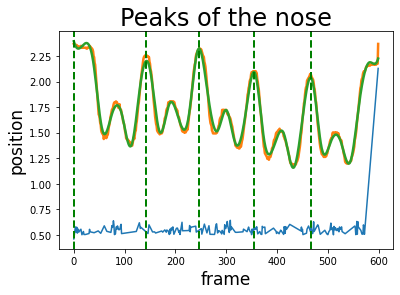

z7T3lqIX
iWDepaRU


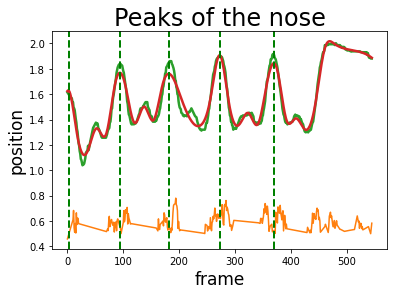

LK6o034V


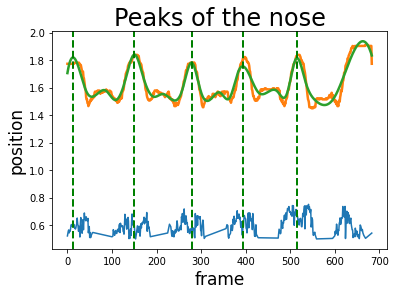

QRGPZHlK


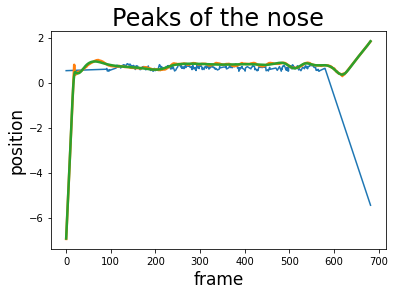

hBNwNT1A


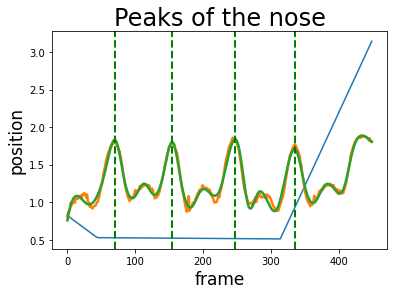

nEdq9NGM


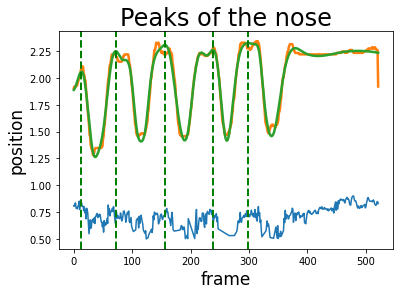

CqjNQOqS


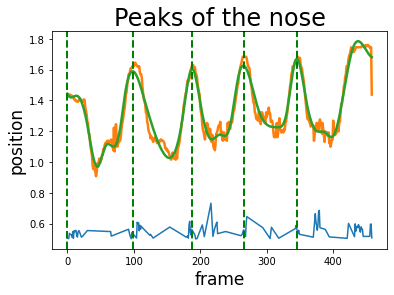

VPR8rhnq


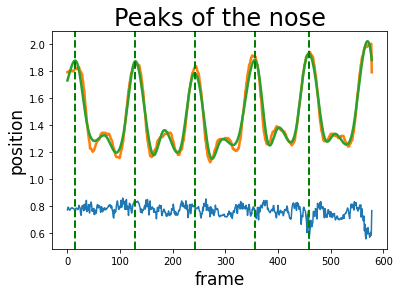

l5NH1DET


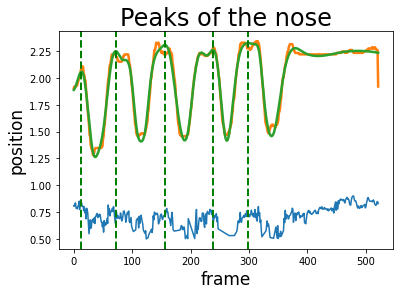

0VI1t1BZ


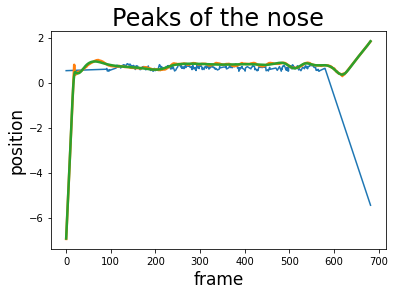

7VgZ1Fni


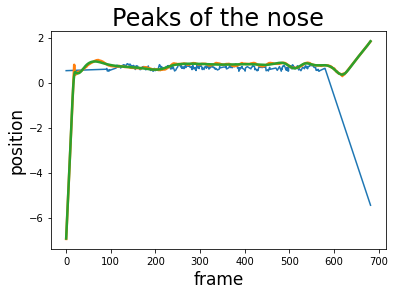

wpl0CrL5


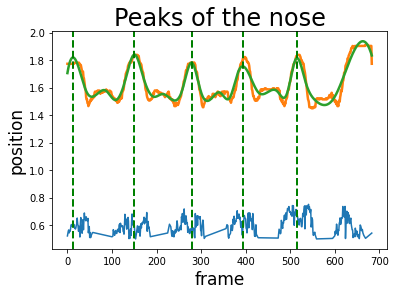

k4Zz5q1I


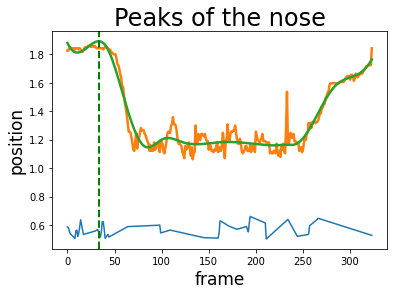

zyW3PPtt
Lp9nWB3K


/home/kidzik/miniconda3/envs/motionlab-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in true_divide
/home/kidzik/miniconda3/envs/motionlab-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/kidzik/miniconda3/envs/motionlab-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/kidzik/miniconda3/envs/motionlab-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


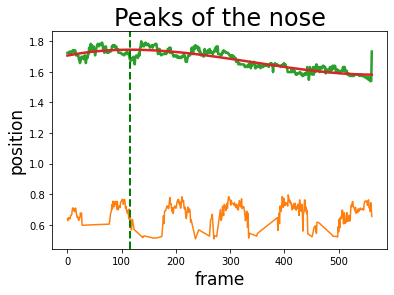

/home/kidzik/miniconda3/envs/motionlab-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in true_divide
/home/kidzik/miniconda3/envs/motionlab-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/kidzik/miniconda3/envs/motionlab-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/kidzik/miniconda3/envs/motionlab-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


9hapShoY


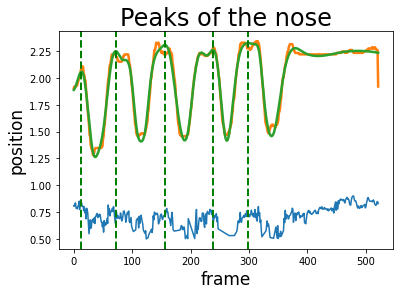

cIZijMLk


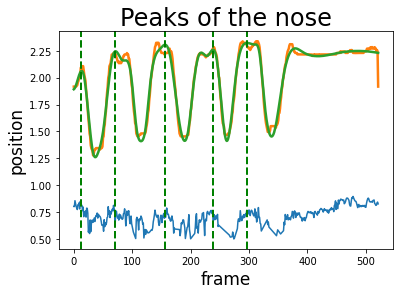

8udRElXs


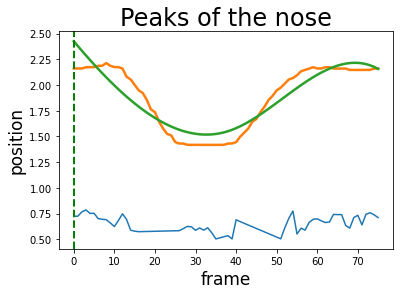

['hozGKSGr', 'z7T3lqIX', 'QRGPZHlK', '0VI1t1BZ', '7VgZ1Fni', 'k4Zz5q1I', 'zyW3PPtt', 'Lp9nWB3K', '8udRElXs']


/home/kidzik/miniconda3/envs/motionlab-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in true_divide
/home/kidzik/miniconda3/envs/motionlab-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/kidzik/miniconda3/envs/motionlab-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/kidzik/miniconda3/envs/motionlab-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [3]:
def process_subject(subjectid):
    res = np.load("videos/np/{}.npy".format(subjectid))

    res[res < 0.5] = np.NaN 
    res = np.apply_along_axis(fill_nan,arr=res,axis=0)
    plt.plot(res[:,RANK])

    res = center_ts(res)
    breaks = get_segments(res)
    #plot_ts(res)

    results = {
        "subjectid": subjectid,
    }
    results.update(get_time_results(res, breaks))
    results.update(get_angles_results(res, breaks))
    results.update(get_acceleration_results(res, breaks))
    return results

subjects = os.listdir("videos/keypoints")

skipped = []
tofix = []

all_res = []

# Convert OpenPose frames to a numpy array
for subjectid in subjects:
    print(subjectid)
    try:
        results = process_subject(subjectid)
    except Exception as e:
        skipped.append(subjectid)
        continue
    all_res.append(results)    
print(skipped)

In [4]:
res_df = pd.DataFrame(all_res)
res_df

,subjectid,n,time,speed,time_sd,speed_sd,left_knee_max,left_knee_min,left_knee_max_sd,left_knee_min_sd,...,right_hip_max,right_hip_min,right_hip_max_sd,right_hip_min_sd,trunk_max,trunk_min,trunk_max_sd,trunk_min_sd,avg_pelvis_acc,avg_neck_acc
0,9QrMwwEK,5,18.458333,0.27,0.168943,0.013104,179.964123,98.640747,0.038094,0.395776,...,179.954749,96.833548,0.114719,2.154082,50.915128,10.219387,1.215466,1.785668,0.000649,0.000649
1,0eHy4fTr,5,15.333333,0.33,0.117851,0.012578,179.700507,61.301455,0.839631,3.418683,...,175.816991,84.244919,4.280635,2.307179,126.359855,21.085103,11.371820,1.744549,0.012284,0.012284
2,BgJDWIJz,7,20.961111,0.24,0.793589,0.126695,179.969137,98.535813,4.079331,27.212300,...,179.871995,112.339872,2.409386,20.498241,179.799689,25.143580,35.213318,3.758826,0.020296,0.020296
3,bzh3pQlt,5,20.916667,0.24,0.283333,0.016343,179.994888,114.249932,0.137906,1.264493,...,179.914520,119.090762,0.380835,23.807591,54.557782,23.248321,3.093483,1.234643,0.006303,0.006303
4,OJk9GuJF,5,19.416667,0.26,0.519348,0.030923,179.988146,82.395993,0.275006,32.352640,...,179.964802,71.548045,0.386547,1.341868,104.930969,0.715557,20.826101,0.229274,0.019572,0.019572
5,iWDepaRU,5,15.333333,0.33,0.117851,0.012578,179.700507,61.301455,0.839631,3.418683,...,175.816991,84.244919,4.280635,2.307179,126.359855,21.085103,11.371820,1.744549,0.012284,0.012284
6,LK6o034V,5,20.916667,0.24,0.283333,0.016343,179.994888,114.249932,0.137906,1.264493,...,179.914520,119.090762,0.380835,23.807591,54.557782,23.248321,3.093483,1.234643,0.006303,0.006303
7,hBNwNT1A,4,11.777778,0.42,0.122726,0.014119,179.881450,93.644060,0.466781,9.382368,...,178.034907,92.042988,5.134905,1.769780,69.943519,6.482375,3.281074,2.740730,0.033168,0.033168
8,nEdq9NGM,5,11.916667,0.42,0.384780,0.069639,177.409584,99.051751,2.665012,1.948313,...,179.682329,105.772438,4.449573,5.264527,48.607157,21.173451,4.741149,1.478849,0.000759,0.000759
9,CqjNQOqS,5,14.375000,0.35,0.277263,0.033139,179.999425,124.522204,0.222312,20.877980,...,179.675581,117.220656,1.275411,1.173041,45.462091,16.693862,1.192933,1.125205,0.001232,0.001232


In [5]:
res_df.to_csv("results.csv")